In [1]:
import numpy as np

import matplotlib.pyplot as plt
from scipy.integrate import odeint
import mpmath as mpmath

# %matplotlib notebook 
%matplotlib inline 

In [2]:
# routines for displacement operator, coherent states and Husimi distribution 

# return Shift operator Xhat as a 2d NxN complex matrix (unitary)   
def Xhat_op(N): # in regular basis 
    X = np.zeros((N,N),dtype=complex)
    for k in range(N):
        X[(k+1)%N,k] = 1.0 + 0j
    return X

# return clock operator Zhat as a 2d NxN complex matrix (unitary)  
def Zhat_op(N):  # in regular basis
    Z = np.zeros((N,N),dtype=complex)
    for k in range(N):
        omegaj = np.exp(2*np.pi*k*1j/N)
        Z[k,k] = omegaj 
    return Z

def Zhat_dagger_op(N):
    return np.conjugate(Zhat_op(N))

def Xhat_dagger_op(N):
    return np.transpose(Xhat_op(N))

def cos_phi_op(N):
    return (Zhat_op(N) + Zhat_dagger_op(N))*0.5

def sin_phi_op(N):
    return (Zhat_op(N) - Zhat_dagger_op(N))/(2.0j)

def cos_p_op(N):
    return (Xhat_op(N) + Xhat_dagger_op(N))*0.5

def sin_p_op(N):
    return (Xhat_op(N) - Xhat_dagger_op(N))/(2.0j)


# create Dhat_kl, the displacement operator as a function of k,l  
# returns an NxN complex matrix, is unitary 
# computes \hat D_{kl} = \omega^{-kl/2} \hat X^l \hat Z^k
# calls routines Xhat_op(N), Zhat_op()
def Displacement_op(N,k,l):
    #D = np.zeros((N,N),dtype=complex)
    omega = np.exp(2*np.pi*1j/N)
    #omfac = np.power(-omega*k*l/2.0)
    X = Xhat_op(N)
    Z = Zhat_op(N)
    Xl = np.linalg.matrix_power(X, l)
    Zk = np.linalg.matrix_power(Z, k)
    Dhat= np.power(omega,-k*l/2.0) * np.matmul(Zk,Xl)
    return Dhat

# computes eigenfunction |\tilde eta> of the QFT 
# returns an N dimensional complex normalized statevector 
# This is a unimodal periodic thing which is peaked at index 0
def eta_tilde(N):
    eta = np.zeros(N,dtype=complex)
    efac = np.exp(-np.pi/N)
    for m in range(N):  # compute using theta function 
        eta[m] = np.real(mpmath.jtheta(3,np.pi*m/N,efac)/np.sqrt(N))
    eta_mag = np.sqrt(np.sum(eta*np.conj(eta)))
    eta = eta/eta_mag   # normalize
    return eta

#  Creat a coherent state from Displacement operator hat D and eigenfunction |tilde eta>
# returns an N dimensional complex normalized state vector 
# calls routines Displacement_op(), eta_tilde()
def coherent_state(N,k,l):
    Dhat = Displacement_op(N,k,l)
    eta=eta_tilde(N)
    ch = np.matmul(Dhat,eta)
    return ch

# make a set of coherent states from QFT eigenfunction |tilde eta> and displacement op Dhat
# returns an N x N x N 3D complex array 
#   the matrix [k,l,:] is the coherent state |k,l>
# calls routines Xhat_op(N), Zhat_op()
def coh_Dkl(N):
    c_matrix = np.zeros((N,N,N),dtype=complex)
    eta=eta_tilde(N)  #only do this once
    omega = np.exp(2*np.pi*1j/N)  #only do this once
    #omfac = np.power(-omega*k*l/2.0)
    X = Xhat_op(N) # only do this once
    Z = Zhat_op(N) # only do this once
    for k in range(N):
        Zk = np.linalg.matrix_power(Z, k)
        for l in range(N):
            Xl = np.linalg.matrix_power(X, l)
            Dhat = np.power(omega,-k*l/2.0) * np.matmul(Zk,Xl)
            #Dhat = Displacement_op(N,k,l)
            c_matrix[k,l,:] = np.matmul(Dhat,eta)  
            # if displacement is in p direction then p increases with l
            # and k increases in x direction 
            # note that imshow displays arrays with [j,k] with j in y direction
    return c_matrix

# make a set of coherent states from QFT eigenfunction |tilde eta> and displacement op
# returns an N x N x N 3D complex array 
#   the matrix [k,l,:] is the coherent state |k,l>
#  a more efficient version 
# calls routines Xhat_op(N), Zhat_op(), eta_tilde()
def coh_Dkl_b(N):
    c_matrix = np.zeros((N,N,N),dtype=complex)
    eta=eta_tilde(N)  #only do this once
    omega = np.exp(2*np.pi*1j/N)  #only do this once
    #omfac = np.power(-omega*k*l/2.0)
    X = Xhat_op(N) # only do this once
    Z = Zhat_op(N) # only do this once
    Zk = np.linalg.matrix_power(Z, 0)
    for k in range(N):
        Xl = np.linalg.matrix_power(X, 0)
        for l in range(N):
            #Xl = np.linalg.matrix_power(X, l)
            Dhat = np.power(omega,-k*l/2.0) * np.matmul(Zk,Xl)
            #Dhat = Displacement_op(N,k,l)
            c_matrix[k,l,:] = np.matmul(Dhat,eta)  
            # if displacement is in p direction then p increases with l
            # and k increases in x direction 
            # note that imshow displays arrays with [j,k] with j in y direction
            Xl = np.matmul(X,Xl)
        Zk = np.matmul(Z,Zk)
    return c_matrix
   
# compute Hussimi distribution of an N dimensional state vector psi 
# in advance you have computed a set of coherent states with above
#    routine coh_Dkl(N) or coh_Dkl_b(N)
# the set of coherent states is given via the argument c_matrix 
#    c_matrix should be an NxNxN matrix 
# the routine returns an NxN real matrix which is the Hussimi function  
#   note that index order is p,x  so that y would be first index, as expected for plotting with imshow
def Husimi(psi,c_matrix):
    N = len(psi)
    H_matrix = np.zeros((N,N))
    cshape = c_matrix.shape
    if (cshape[0] != N):
        print('c_matrix is wrong dimension')
    for k in range(N):
        for l in range(N):
            co_kl = np.squeeze(c_matrix[k,l,:])  #coherent state |k,l> -p,x
            mag = np.vdot(psi,co_kl) # dot product
            mag = np.absolute(mag) # is real 
            H_matrix[k,l] = mag**2  

    return H_matrix

In [3]:
# compute the propagator U across tau =0 to  2 pi
# trying a somewhat more efficient way to do this!
#  arguments:
#     N      : size of discrete quantum space 
#     ntau   : how many Trotterized steps to take 
#     a,b,eps,mu,mup,taushift      : parameters of classical model, all unitless 
#  returns:  
#    Ufinal  : The propagator hat U_T  (NxN complex matrix)
#    w       : vector of eigenvalues of U in order of increasing phase
#    vr      : vector of associated eigenfunctions of U 
#        vr[:,j] is the eigenvector with eigenvalue w[j]
# note we have shifted indexing so that phi=0, p=0 is in the center of the 2d arrays
# calls routine esort_phase()
def U_prop2(N,ntau,a,b,eps,mu,mup,taushift):
    DLambda_A =np.zeros((N,N),dtype=complex)  # storing diagonal matrix for momentum part
    DLambda_Ah =np.zeros((N,N),dtype=complex)  # storing diagonal matrix for momentum part
    DLambda_Ahm =np.zeros((N,N),dtype=complex)  # storing diagonal matrix for momentum part
    DLambda_B =np.zeros((N,N),dtype=complex)  # storing diagonal matrix for phi part
    U_final  =np.zeros((N,N),dtype=complex)  # final propagator
    #Efac = N**2/(4.0*np.pi*ntau)    # includes dtau , is wrong
    Efac = N/ntau    # Bohr Sommerfeld type quantization gives this
    # this is L_0/hbar x 2pi/ntau = N/2pi x 2pi/ntau = N/ntau, is correct , includes dtau
    
    dtau = 2*np.pi/ntau  # step size 
    Q_FT,Q_FT_dagger = QFT(N)  # need only be computed once
    for k in range(N):  #compute ahead of time, fill diagonals
        pk = 2*np.pi*k/N - np.pi  # shifted so 0,0 in center of arrays
        DLambda_Ah[k,k] = np.exp(-0.5j*Efac*a*(1.0 - np.cos(pk-b))) #diagonal in Fourier basis
        DLambda_A[k,k]  = np.exp(  -1j*Efac*a*(1.0 - np.cos(pk-b))) 
        DLambda_Ahm[k,k]= np.exp( 0.5j*Efac*a*(1.0 - np.cos(pk-b))) 
        # these are half step and full step for the momentum part
        
    LAh     = np.matmul(Q_FT,np.matmul(DLambda_Ah ,Q_FT_dagger))  # transfer basis 
    LA      = np.matmul(Q_FT,np.matmul(DLambda_A  ,Q_FT_dagger))   
    LAh_inv = np.matmul(Q_FT,np.matmul(DLambda_Ahm,Q_FT_dagger))
    
    U_final = LAh;  #inverse half step at the beginning 
        
    for i in range(ntau): # each dtau
        tau = i*dtau + taushift # time of propagator shifted by taushift
        for j in range(N):
            phi = 2*np.pi*j/N - np.pi  # shifted so 0,0 in center of arrays 
            DLambda_B[j,j] = np.exp(1j*Efac*(\
                eps*np.cos(phi)+mu*np.cos(phi-tau)+mup*np.cos(phi+tau) )) # create diagonal matrix 
            # note sign of 1j 
        U_final = np.matmul(LA,np.matmul(DLambda_B,U_final))
        
    U_final = np.matmul(LAh_inv,U_final)
    
    (w,vr)=np.linalg.eig(U_final)  # get eigenvalues and eigenvectors
    w_s,vr_s = esort_phase(w,vr)   # sort in order of increasing eigenvalue phase
    return w_s,vr_s,U_final 
            
            

In [56]:
# compute the propagator U(tau)  but not all the way to 2 pi!
#  arguments:
#     N      : size of discrete quantum space 
#     ntau   : how many Trotterized steps to take 
#     a,b,eps,mu,mup,taushift      : parameters of classical model, all unitless 
#     ftau: now many tausteps to actually take 
#  returns:  
#    Ufinal  : The propagator hat U_T  (NxN complex matrix)
#    w       : vector of eigenvalues of U in order of increasing phase
#    vr      : vector of associated eigenfunctions of U 
#        vr[:,j] is the eigenvector with eigenvalue w[j]
# note we have shifted indexing so that phi=0, p=0 is in the center of the 2d arrays
# calls routine esort_phase()
def U_prop3(N,ntau,a,b,eps,mu,mup,taushift,ftau):
    DLambda_A =np.zeros((N,N),dtype=complex)  # storing diagonal matrix for momentum part
    DLambda_Ah =np.zeros((N,N),dtype=complex)  # storing diagonal matrix for momentum part
    DLambda_Ahm =np.zeros((N,N),dtype=complex)  # storing diagonal matrix for momentum part
    DLambda_B =np.zeros((N,N),dtype=complex)  # storing diagonal matrix for phi part
    U_final  =np.zeros((N,N),dtype=complex)  # final propagator
    #Efac = N**2/(4.0*np.pi*ntau)    # includes dtau , is wrong
    Efac = N/ntau    # Bohr Sommerfeld type quantization gives this
    # this is L_0/hbar x 2pi/ntau = N/2pi x 2pi/ntau = N/ntau, is correct , includes dtau
    
    dtau = 2*np.pi/ntau  # step size 
    Q_FT,Q_FT_dagger = QFT(N)  # need only be computed once
    for k in range(N):  #compute ahead of time, fill diagonals
        pk = 2*np.pi*k/N - np.pi  # shifted so 0,0 in center of arrays
        DLambda_Ah[k,k] = np.exp(-0.5j*Efac*a*(1.0 - np.cos(pk-b))) #diagonal in Fourier basis
        DLambda_A[k,k]  = np.exp(  -1j*Efac*a*(1.0 - np.cos(pk-b))) 
        DLambda_Ahm[k,k]= np.exp( 0.5j*Efac*a*(1.0 - np.cos(pk-b))) 
        # these are half step and full step for the momentum part
        
    LAh     = np.matmul(Q_FT,np.matmul(DLambda_Ah ,Q_FT_dagger))  # transfer basis 
    LA      = np.matmul(Q_FT,np.matmul(DLambda_A  ,Q_FT_dagger))   
    LAh_inv = np.matmul(Q_FT,np.matmul(DLambda_Ahm,Q_FT_dagger))

    U_final = LAh;  #inverse half step at the beginning 
        
    for i in range(ftau): # each dtau
        tau = i*dtau + taushift # time of propagator shifted by taushift
        for j in range(N):
            phi = 2*np.pi*j/N - np.pi  # shifted so 0,0 in center of arrays 
            DLambda_B[j,j] = np.exp(1j*Efac*(\
                eps*np.cos(phi)+mu*np.cos(phi-tau)+mup*np.cos(phi+tau) )) # create diagonal matrix 
            # note sign of 1j 
        U_final = np.matmul(LA,np.matmul(DLambda_B,U_final))
        
    U_final = np.matmul(LAh_inv,U_final)
    
    (w,vr)=np.linalg.eig(U_final)  # get eigenvalues and eigenvectors
    w_s,vr_s = esort_phase(w,vr)   # sort in order of increasing eigenvalue phase
    return w_s,vr_s,U_final 
            

In [4]:

# fill matrices with Discrete Fourier transform, returns 2 nxn matrices
# both Q_FT and Q_FT^dagger which is the inverse 
def QFT(n):
    omega = np.exp(2*np.pi*1j/n)
    Q        = np.zeros((n,n),dtype=complex)  # QFT
    Q_dagger = np.zeros((n,n),dtype=complex) 
    for j in range(n):
        for k in range(n):
            Q[j,k] = np.power(omega,j*k)  # not 100% sure about sign here! 
            Q_dagger[j,k] = np.power(omega,-j*k)
    Q        /= np.sqrt(n)  #normalize
    Q_dagger /= np.sqrt(n)
    return Q,Q_dagger 


# sort eigenvalues and eigenvectors in order of increasing phase
# eigenvectors from np.linalg.eig are in form vr[:,j]
# argument: w eigenvalues, vr eigenvectors
# we assume that w consists of quasienergies which are complex numbers of magnitude 1
def esort_phase(w,vr):
    phi_arr = np.angle(w) # get the phase angles in [-pi,pi] of complex numbers
    iphi = np.argsort(phi_arr) # in order of increasing phase
    wsort = w[iphi]
    vrsort = np.copy(vr)*0.0
    for i in range(len(w)):
        vrsort[:,i] = vr[:,iphi[i]]
    #vrsort = vr[:,iphi]  # does this work? I think so! yes
    return wsort,vrsort


In [5]:
# compute the expectation value of operator, using a state vector evec 
# returns <evec|op|evec>
def exp_val(evec,op):
    zvec = np.matmul(op,evec)   # compute op|evec>
    w = np.vdot(evec,zvec)   # complex dot product, evec is conjugated prior to doing the dot product 
    return w 

# compute the commutator of two operators [op1,op2] = op1 op2 - op2 op1
def commutator(op1,op2):
    return np.matmul(op1,op2) - np.matmul(op2,op1)

# sort a set of eigenvalues and eigenfunctions according to the expectation value of an operator 
# returns expectation values and dispersions 
# arguments:
#    w  a vector of eigenvals (dim n)
#    vr a vector of eigenstates w_j vr[:,j] is a single one (dim nxn)
#    op an operator (dim nxn)
#  returns:
#    wsort:  sorted w in order of <w_j|op|w_j> 
#    vrsort: sorted w_j in order of <w_j|op|w_j>
#    expsort: values of <w_j\op|w_j> in increasing order
#    sigsort: values of dispersion <w_j|op^2|w_j> -  <w_j|op|w_j>^2)^2
def esort_op(w,vr,op):
    n = len(w)
    exp_arr = np.zeros(n,dtype=complex) # to store the expectation values  <op>
    sig_arr = np.zeros(n,dtype=complex) # to store <op^2> - <op>^2
    for i in range(n):
        mu =  exp_val(np.squeeze(vr[:,i]), op)  #h
        mu2 = exp_val(np.squeeze(vr[:,i]), np.matmul(op,op)) #h^2
        sig2 = mu2-mu*mu # compute dispersion too 
        exp_arr[i] = mu
        sig_arr[i] = sig2  # notice is dispersion not std
        # compute the expectation values of the operator for every eigenfunction 
    iphi = np.argsort(np.real(exp_arr)) # sort in order of increasing expectation value 
    wsort = w[iphi]  # sort the eigenvalues 
    expsort = exp_arr[iphi] # sort the expectation values 
    sigsort = sig_arr[iphi] # sort the dispersions 
    vrsort = np.copy(vr)*0.0 # to store the eigenfunctions in order of expectation vals
    for i in range(len(w)):
        vrsort[:,i] = vr[:,iphi[i]]  # sort the eigenfunctions which are vr[:,j]

    return wsort,vrsort,expsort,sigsort

#wsort,vrsort,expsort,sigsort = esort_op(w,vr,op)

# unperturbed hamiltonian operator 
# calls routines cos_p_op(), cos_phi_op()
def hat_h_0_new(N,a,eps):
    return a*(np.identity(N) - cos_p_op(N)) - eps*cos_phi_op(N)

# get and return eigenvalues and eigenvecs of unperturbed hamiltonian h0 but in order of increasing eigenvalue
# calls routine hat_h_0_new()
def eigs_h0(n,a,eps):
    H0op = hat_h_0_new(n,a,eps) # store unperturbed hamiltonian op hat h_0
    (w,vr)=np.linalg.eig(H0op)  # get eigenvalues and eigenvectors
    iphi = np.argsort(np.real(w)) # in order of increasing energy
    wsort = np.real(w[iphi])
    vrsort = np.copy(vr)*0.0
    for i in range(len(w)):
        vrsort[:,i] = vr[:,iphi[i]]  # sort eigenvectors 
    return wsort,vrsort

# H0op = hat_h_0_new(n,a,eps) 
# wsort,vrsort = eigs_h0(n,a,eps)

In [6]:
# compute <v_j|op|v_k> return quantity (complex number)
def jk_el(v_j,op,v_k):
    z = np.matmul(op,v_k)
    return np.vdot(v_j,z)

#el = jk_el(v_j,op,v_k)

# fill a matrix with <j op k> computed with a list of states vr[:,j]
def el_matrix(vr,op):
    n = vr.shape[0]
    el_mat = np.zeros((n,n),dtype =complex)
    for j in range(n):
        v_j = np.squeeze(vr[:,j])
        for k in range(n):
            v_k = np.squeeze(vr[:,k])
            el = jk_el(v_j,op,v_k)
            el_mat[j,k] = el
    return el_mat

#el_mat = el_matrix(vr,op)

# fill a matrix with <vr|wr> for two lists of states
def state_prod(vr,wr):
    n = vr.shape[0]
    mat = np.zeros((n,n),dtype =complex)
    for j in range(n):
        v_j = np.squeeze(vr[:,j])
        for k in range(n):
            w_k = np.squeeze(wr[:,k])
            mat[j,k] = np.vdot(v_j,w_k)
    return mat

#mat = state_prod(vr,wr)

# multiply a matrix op by a matrix of values, then sum absolute square of elements over k. 
# return a vector of sum of square of matrix values and pointlessly the absolute value of square of matrix elements as a matrix
def Vjksum(a_matrix,mat):
    n = a_matrix.shape[0]
    a_sum = np.zeros(n)
    pp = np.multiply(a_matrix,mat) # elementwise multiply
    pp2 = np.absolute(pp)**2  # all matrix elements are ||^2
    for j in range(n):
        a_sum[j] = np.sum(np.squeeze(pp2[j,:])) # sum over square of matrix elements 
        #np.absolute(np.sum(pp[j,:])) # is | | of sum of the k matrix elements
    return a_sum,pp2

#a_sum,pp2 = Vjksum(a_matrix,mat)

# return diagonal of a square matrix 
def mdiag(xmat):
    n = xmat.shape[0]
    diag = np.zeros(n, dtype = complex)
    for i in range(n):
        diag[i] = xmat[i,i]
    return diag
    

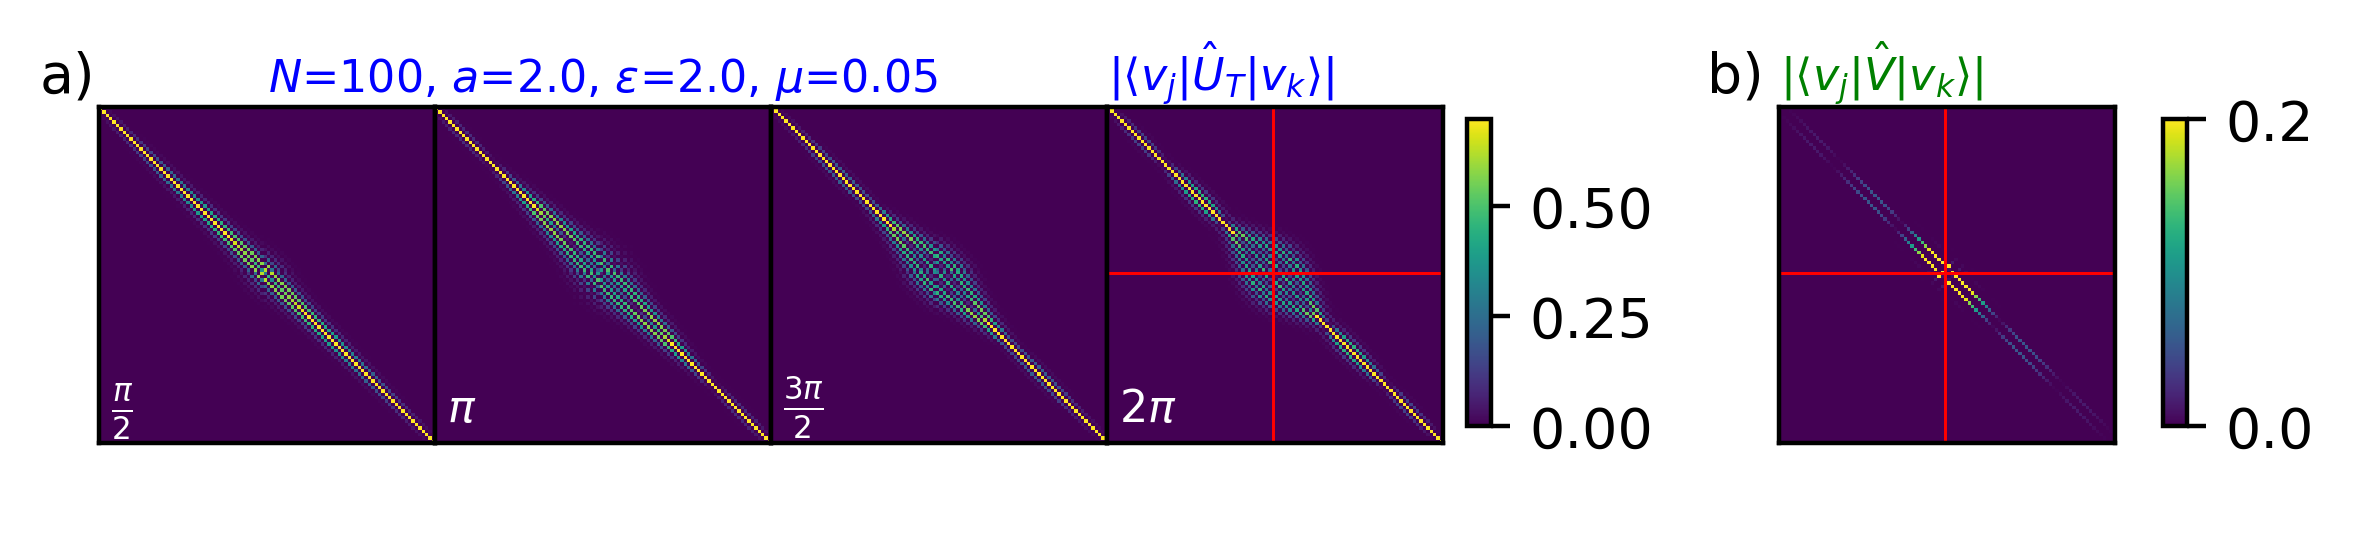

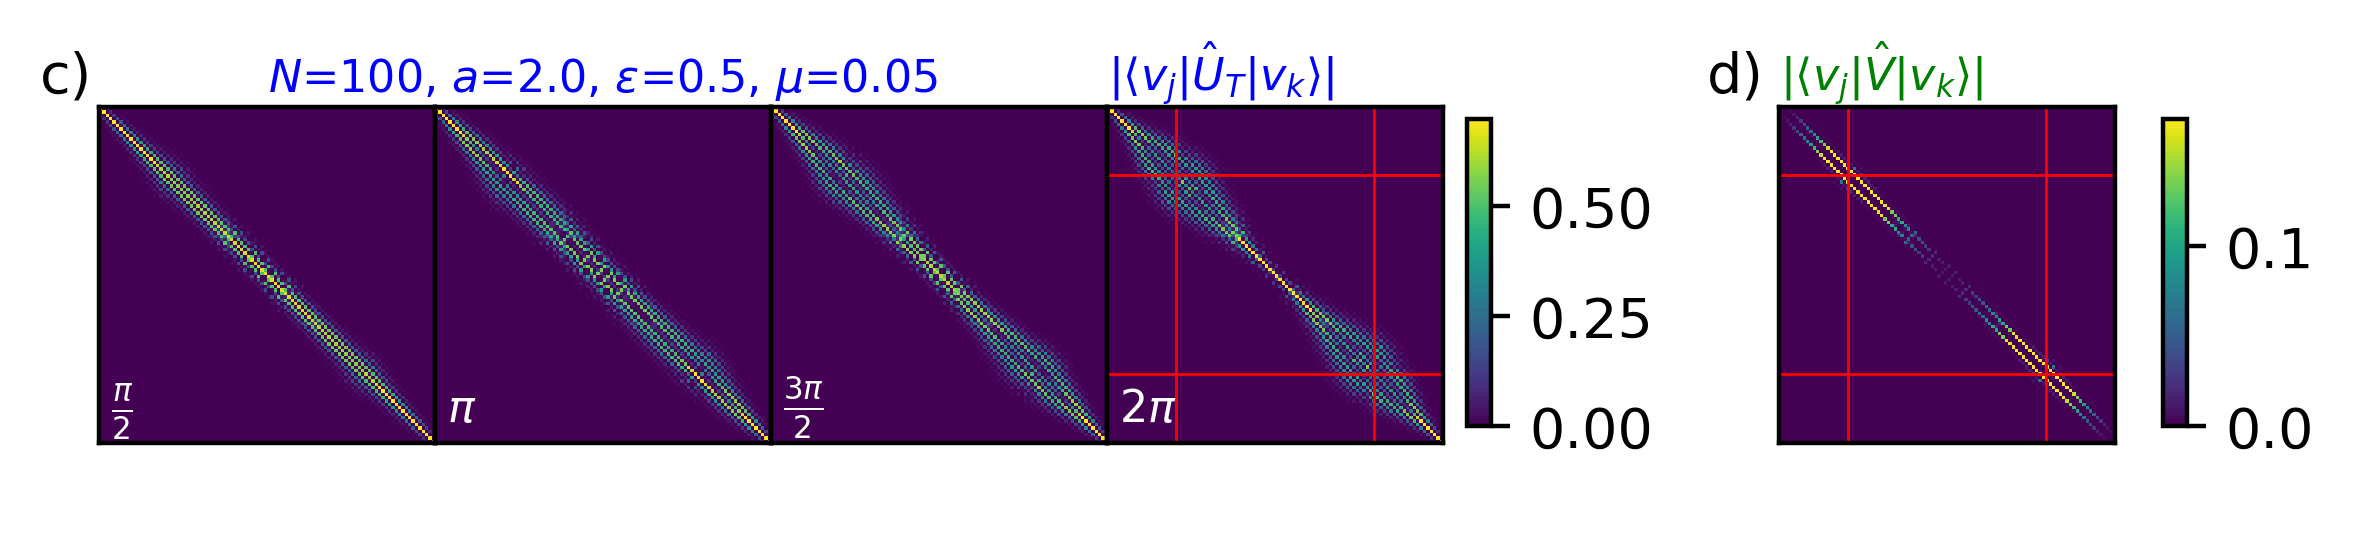

In [305]:
# create the matrix V_{jk} 
# elements are returned but currently lack complex phases 
# returns complex nxn array of matrix elements 
# computed in eigenbasis of h0
def mk_Vjk(n,a,eps):
    c_op = cos_phi_op(n)  # cos phi operator 
    h0 = hat_h_0_new(n,a,eps)  # unperturbed Hamiltonian 
    w, vr = eigs_h0(n,a,eps)  # energies and eigenstates of h0
    cop_jk = el_matrix(vr,c_op)  # expectation values of cos phi
    mat = np.zeros((n,n),dtype = complex)
    mat_V = np.zeros((n,n),dtype = complex)
    for j in range(n):
        for k in range(n):
            E_jk = w[j]- w[k]
            fac1 = np.exp(1j*n*E_jk) - 1.0
            fac2 = (n*E_jk/(2*np.pi))**2 - 1.0
            fac3 = n*E_jk/(2*np.pi)
            if (fac3 !=0):
                mat[j,k] = fac1*fac3/fac2 

    mat *= 1/(2*np.pi)  # these are the functions for hat_F_{jk}, ignoring complex phases 
    mat_V = mat*cop_jk
    return mat_V

# make a figure showing matrix elements of propagator (Trotterized to 4 different times)
# and also showing the matrix elements of V_jk 
# matrix elements computed in the eigenbasis of h_0
def do6(n,a,eps,mu,la1,la2,ofile):
    #a = 1.0; eps=1.0; mu=0.05;  
    mup = mu;
    b=0.; taushift=0.
    #n = 100; 
    ntau = n*4
    h0 = hat_h_0_new(n,a,eps)  # unperturbed hamiltonian 
    w, vr = eigs_h0(n,a,eps)   # its energies and eigenstates 
    
    nw=6
    fig,axarr = plt.subplots(1,nw,figsize=(6,1.2),dpi=400)
    plt.subplots_adjust(hspace=0,wspace=0,top=0.92,right=0.87,bottom=0.01,left=0.03)
    for k in range(nw):
        axarr[k].set_yticks([])
        axarr[k].set_xticks([])

    axarr[0].text(-18,-5,la1,fontsize=10)
    axarr[5].text(-22,-5,la2,fontsize=10)

    nk = 4
    for k in range(nk):
        ftau = int((k+1)*ntau/nk)
        w_s,vr_s,U_final  = U_prop3(n,ntau,a,b,eps,mu,mup,taushift,ftau) 
        # compute propagator out to ftau steps
        ela = el_matrix(vr,U_final) # compute matrix elements 
        if (k==0):
            vmin = np.min(np.abs(ela))
            vmax = np.max(np.abs(ela))
        im=axarr[k].imshow(np.abs(ela),vmin=vmin,vmax=vmax*0.7)

    cax= fig.add_axes([0.6,0.15,0.01,0.64])
    plt.colorbar(im,cax=cax)
    clabel = r'$N$={:0}, $a$={:.1f}, $\epsilon$={:.1f}, $\mu$={:.2f}'.format(n,a,eps,mu)
    axarr[0].text(n/2,-5,clabel,color='blue',fontsize=8)

    ulabel = r'$|\langle v_j| \hat U_T |v_k\rangle |$'
    axarr[3].text(0,-5,ulabel,color='blue',fontsize=8)
    vlabel = r'$|\langle v_j| \hat V |v_k\rangle |$'
    axarr[nw-1].text(0,-5,vlabel,color='green',fontsize=8)

    # show separatrix energies
    E1 = eps
    E2 = 2*a - eps
    i1 = np.argmin(np.abs(w - E1))
    i2 = np.argmin(np.abs(w - E2))
    di = 3
    axarr[nk-1].plot([0,n-1],[i1,i1],'r-',lw=0.5)
    axarr[nk-1].plot([i1,i1],[0,n-1],'r-',lw=0.5)
    axarr[nk-1].plot([0,n-1],[i2,i2],'r-',lw=0.5)
    axarr[nk-1].plot([i2,i2],[0,n-1],'r-',lw=0.5)

    #alabels8 = [r'$\frac{\pi}{4}$', r'$\frac{\pi}{2}$', r'$\frac{3\pi}{4}$', r'$\pi$', \
    #               r'$\frac{5\pi}{4}$', r'$\frac{3\pi}{2}$',  r'$\frac{7\pi}{4}$', r'$2\pi$']
    alabels4 = [r'$\frac{\pi}{2}$', r'$\pi$', \
                   r'$\frac{3\pi}{2}$', r'$2\pi$']
    
    for k in range(nk):
        axarr[k].text(3,n-7,alabels4[k],fontsize=8,color='white')

    # compute the matrix elements of V
    mat_V = mk_Vjk(n,a,eps)
    kv = nw-1
    vmax = np.max(np.abs(mat_V))
    im=axarr[kv].imshow(np.abs(mat_V),vmin=0, vmax=0.7*vmax) # display V_jk 
    cax= fig.add_axes([0.89,0.15,0.01,0.64])
    plt.colorbar(im,cax=cax)

    axarr[nw-2].set_axis_off()
    
    axarr[kv].plot([0,n-1],[i1,i1],'r-',lw=0.5)
    axarr[kv].plot([i1,i1],[0,n-1],'r-',lw=0.5)
    axarr[kv].plot([0,n-1],[i2,i2],'r-',lw=0.5)
    axarr[kv].plot([i2,i2],[0,n-1],'r-',lw=0.5)

    if (len(ofile) >3):
        plt.savefig(ofile)
        
    plt.show()

a = 2.0; eps=a; mu=0.05; n=100
do6(n,a,eps,mu,'a)','b)','pufV1.png')
a = 2; eps=0.5; mu=0.05; n=100
do6(n,a,eps,mu,'c)','d)','pufV2.png')
# showing matrix elements in basis of h0

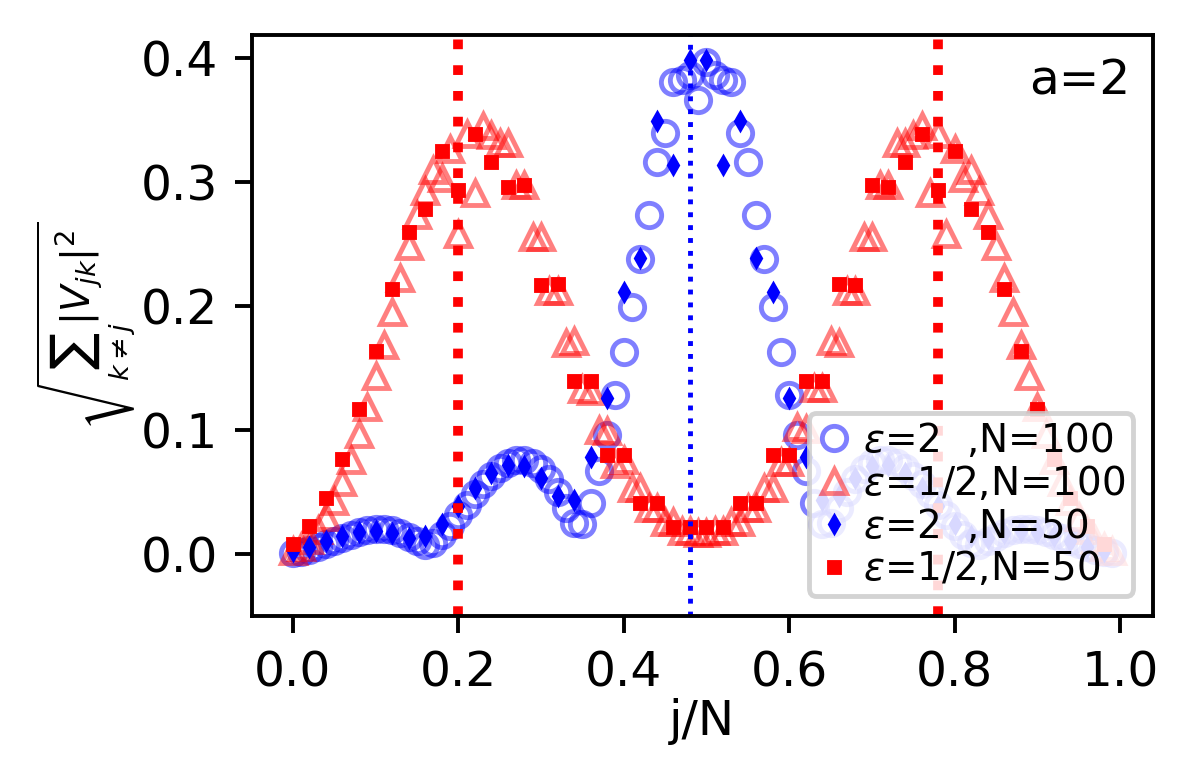

In [331]:
# return a vector of sum_k|V_{jk}|^2
def sum_Vjk(n,a,eps):
    mat_V = mk_Vjk(n,a,eps)  # compute matrix elements V_jk
    mat_V2 = np.absolute(mat_V)**2  # square of magnitudes for each matrix element
    a_sum = np.zeros(n, dtype = float)
    for j in range(n):
        a_sum[j] = np.sum(np.squeeze(mat_V2[j,:])) # sum over square of matrix elements for each j

    w, vr = eigs_h0(n,a,eps)   # its energies and eigenstates 
    E1 = eps  # separatrix energies 
    E2 = 2*a - eps
    i1 = np.argmin(np.abs(w - E1))
    i2 = np.argmin(np.abs(w - E2))
    i1  = float(i1/n)
    i2  = float(i2/n)
    return a_sum, i1, i2 

# make a figure that shows the sum of the matrix elements 
a = 2.0; eps=2.0;  n=100
iia = np.arange(n)/n
a_sum_1,au1,ad1 = sum_Vjk(n,a,eps)
eps=0.5;  
a_sum_2,au2,ad2 = sum_Vjk(n,a,eps)

a = 2.0; eps=2.0;  n=50
iib = np.arange(n)/n
b_sum_1,bu1,bd1 = sum_Vjk(n,a,eps)
eps=0.5;  
b_sum_2,bu2,bd2 = sum_Vjk(n,a,eps)

dosq=1  # show the square of the summed amplitude 
if (dosq==1):
    a_sum_1 = np.sqrt(a_sum_1)
    a_sum_2 = np.sqrt(a_sum_2)
    b_sum_1 = np.sqrt(b_sum_1)
    b_sum_2 = np.sqrt(b_sum_2)
    ylabel = r'$\sqrt{\sum_{k\ne j} |V_{jk}|^2}$'
else:
    ylabel = r'$\sum_{k\ne j} |V_{jk}|^2$'
    
fig,ax = plt.subplots(1,1,figsize=(3.3,2.1),dpi=350)
plt.subplots_adjust(bottom=0.19,top=0.98,right=0.98,left=0.2)
ax.plot(iia,a_sum_1,'bo',ms=5,label=r'$\epsilon$=2  ,N=100',alpha=0.5,markerfacecolor='none')
ax.plot(iia,a_sum_2,'r^',ms=5,label=r'$\epsilon$=1/2,N=100',alpha=0.5,markerfacecolor='none')
ax.plot(iib,b_sum_1,'bd',ms=2,label=r'$\epsilon$=2  ,N=50')
ax.plot(iib,b_sum_2,'rs',ms=2,label=r'$\epsilon$=1/2,N=50')
ax.set_xlabel('j/N',labelpad=0.3)
ax.set_ylabel(ylabel,labelpad=0.3,fontsize=8)
plt.legend(fontsize=8,borderpad=0.2,labelspacing=0.1,handlelength=0.9,handletextpad=0.3,loc='lower right',\
             framealpha=0.85)
ax.text(0.89,0.37,'a=2')

ax.set_ylim(bottom=-0.05)
ymin, ymax = ax.get_ylim()
ax.plot([bu1,bu1],[ymin,ymax],'b:',lw=1)
ax.plot([bd2,bd2],[ymin,ymax],'r:',lw=2)
ax.plot([bu2,bu2],[ymin,ymax],'r:',lw=2)
plt.savefig('sqrtVjk.png')
plt.show()


In [ ]:
I think this works! 

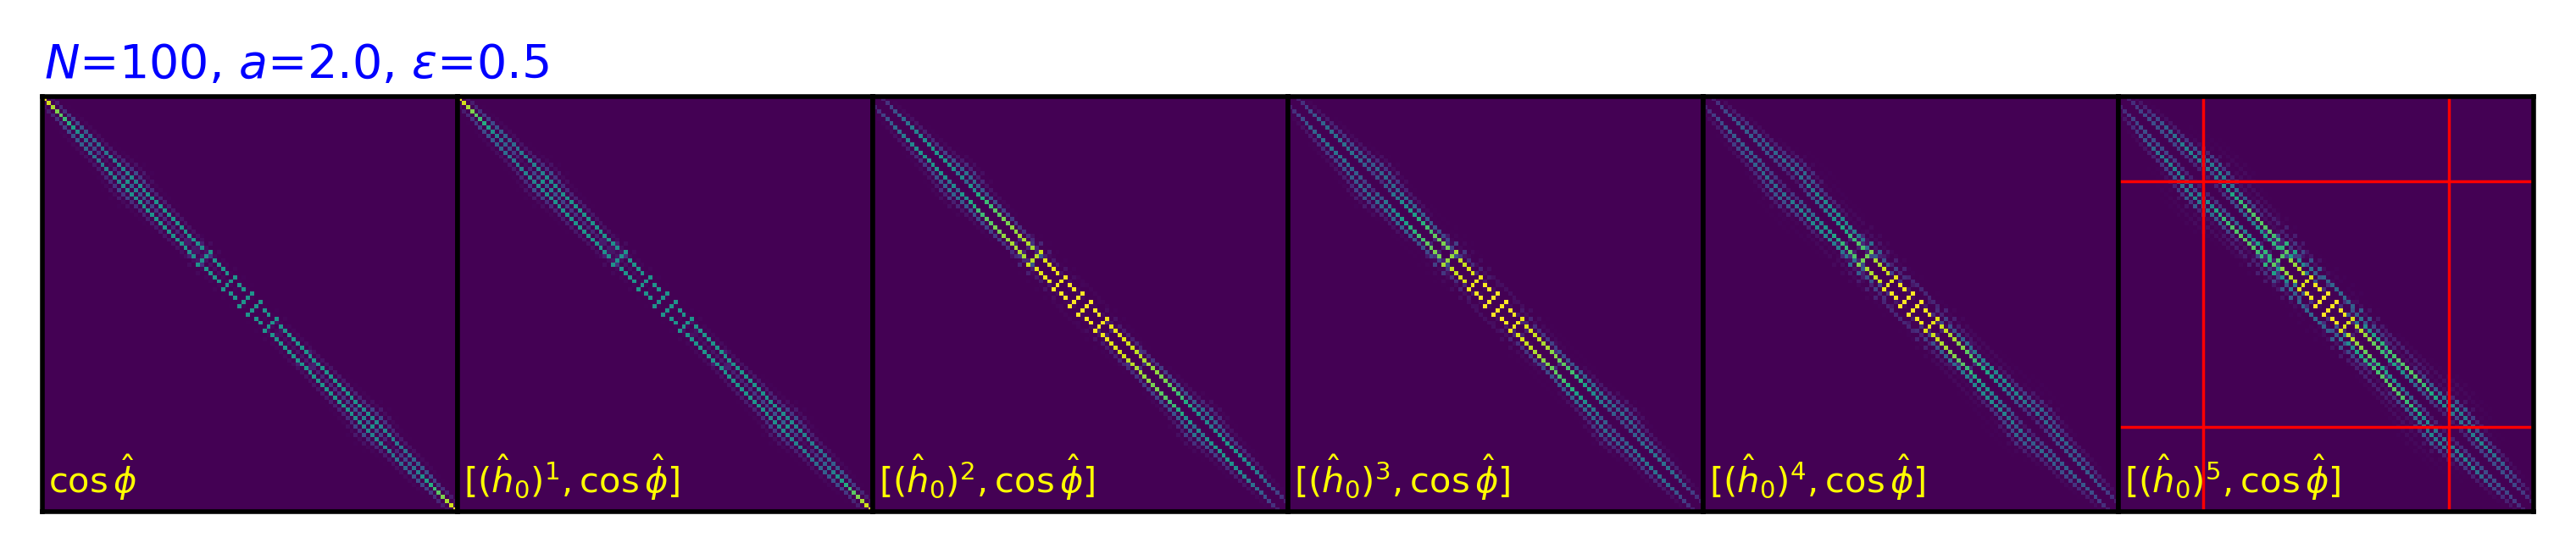

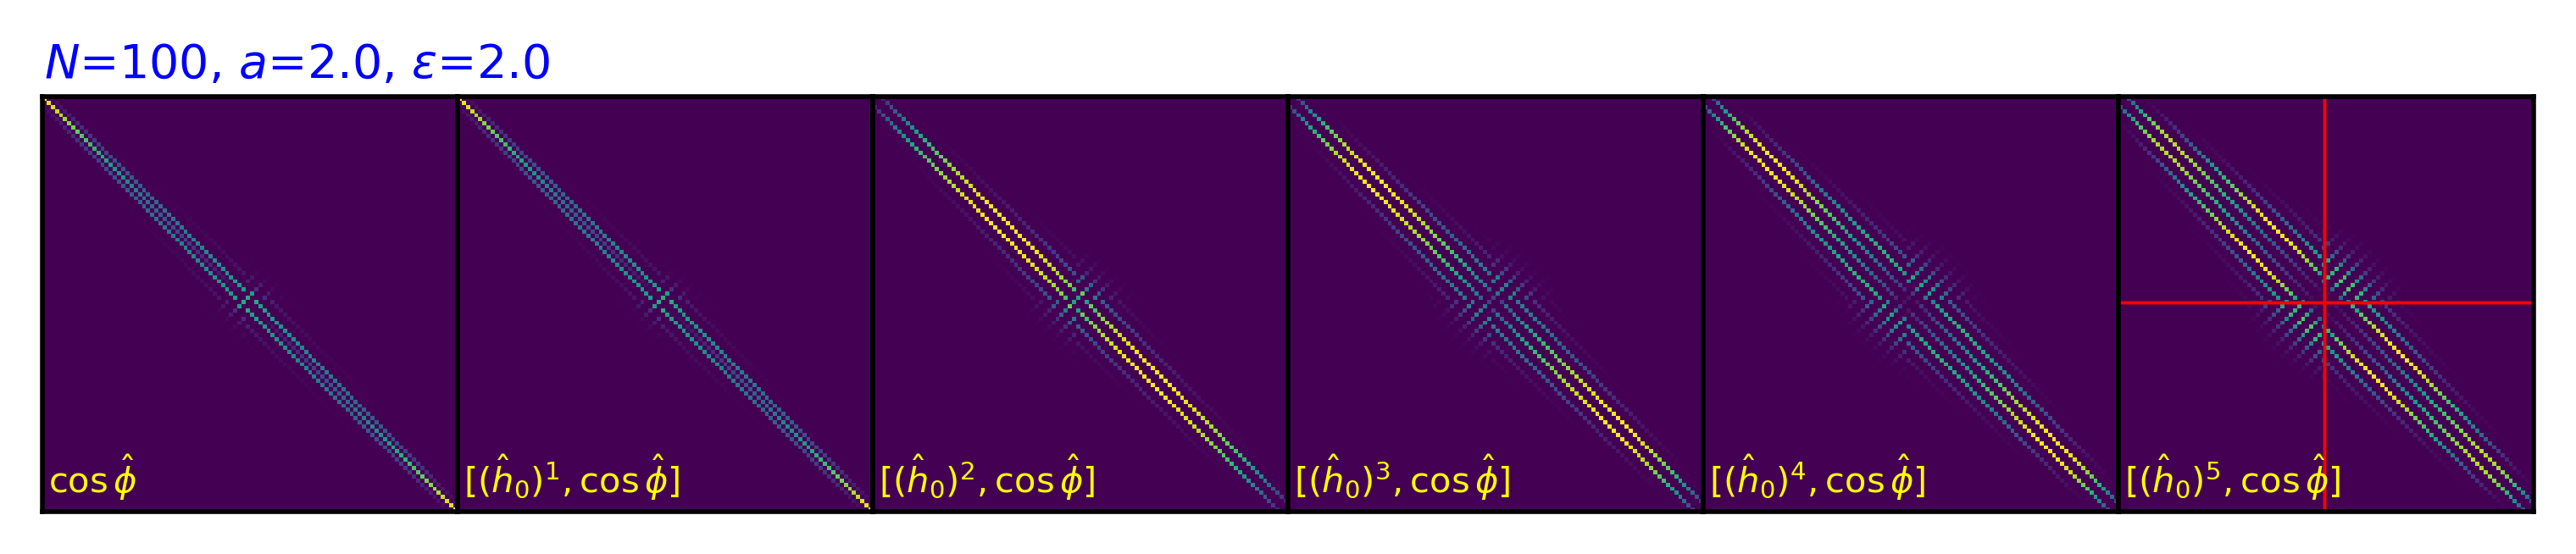

In [235]:
def comseries(n,a,eps,ofile):
    c_op = cos_phi_op(n)
    h0 = hat_h_0_new(n,a,eps)
    w, vr = eigs_h0(n,a,eps)
    cop_jk = el_matrix(vr,c_op)
    #asum1,pp = Vjksum(sop_jk,1)
    #asum2,pp = Vjksum(cop_jk,1)
    nw=6
    fig,axarr= plt.subplots(1,nw,figsize=(6,1.4),dpi=500)
    plt.subplots_adjust(hspace=0,wspace=0,top=0.96,bottom=0.01,left=0.01,right=0.99)
    for k in range(nw):
        im=axarr[k].imshow(np.abs(cop_jk))
        cop_jk = el_matrix(vr,c_op)
        c_op = commutator(h0, c_op)
        axarr[k].set_xticks([])
        axarr[k].set_yticks([])
        if (k==0):
             klabel = r'$\cos \hat \phi$'
        else:
            klabel = r'$[(\hat h_0)^{:0},\cos \hat \phi]$'.format(k)
        #print(klabel)
        axarr[k].text(1,n-n/20,klabel,fontsize=6,color='yellow')
    
    E1 = eps
    E2 = 2*a - eps
    i1 = np.argmin(np.abs(w - E1))
    i2 = np.argmin(np.abs(w - E2))

    axarr[nw-1].plot([0,n-1],[i1,i1],'r-',lw=0.5)
    axarr[nw-1].plot([i1,i1],[0,n-1],'r-',lw=0.5)
    axarr[nw-1].plot([0,n-1],[i2,i2],'r-',lw=0.5)
    axarr[nw-1].plot([i2,i2],[0,n-1],'r-',lw=0.5)
    clabel = r'$N$={:0}, $a$={:.1f}, $\epsilon$={:.1f}'.format(n,a,eps)
    axarr[0].text(0,-5,clabel,color='blue',fontsize=8)

    if (len(ofile)>3):
        plt.savefig(ofile)
    
    plt.show()

n=100;a=2.;eps=0.5; 
comseries(n,a,eps,'com1.png')
a=2.;eps=a;
comseries(n,a,eps,'com2.png')


In [ ]:
# plotting matrix elements of consecutive commutators [h0^n,cos phi] = [h0, [h0, [h0, cos phi]]]]

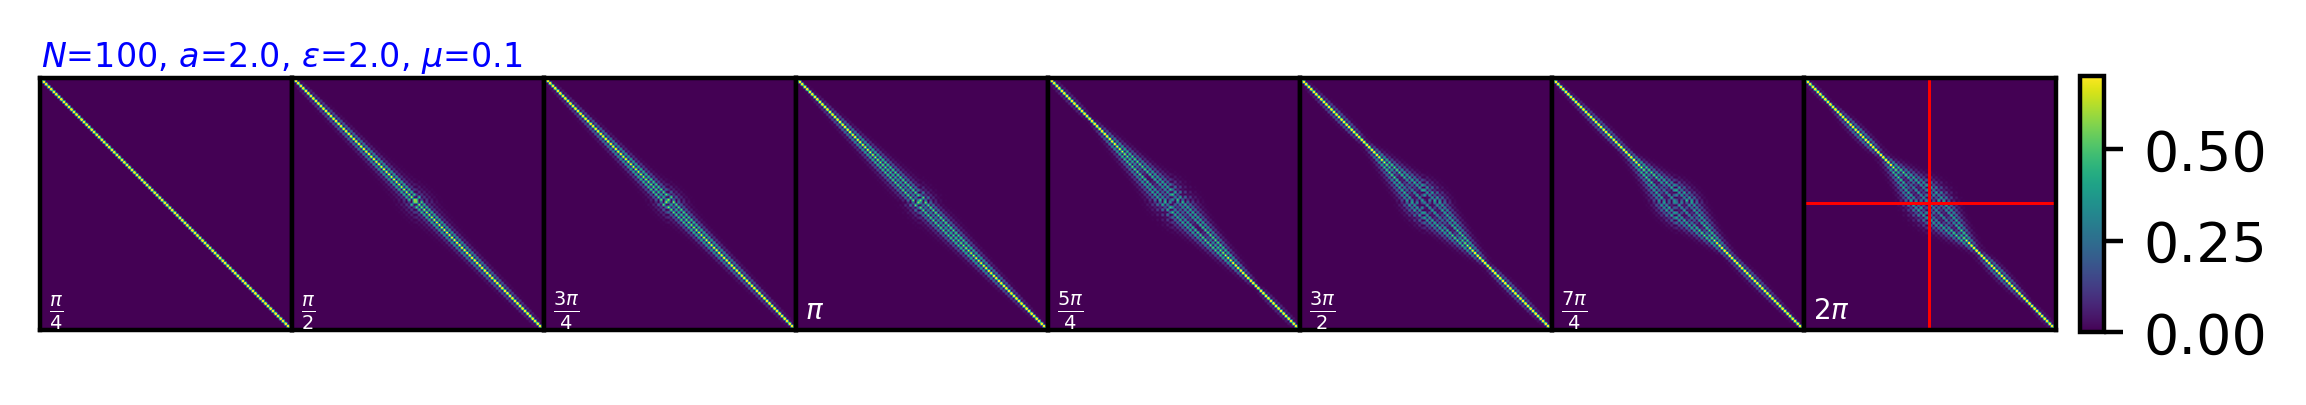

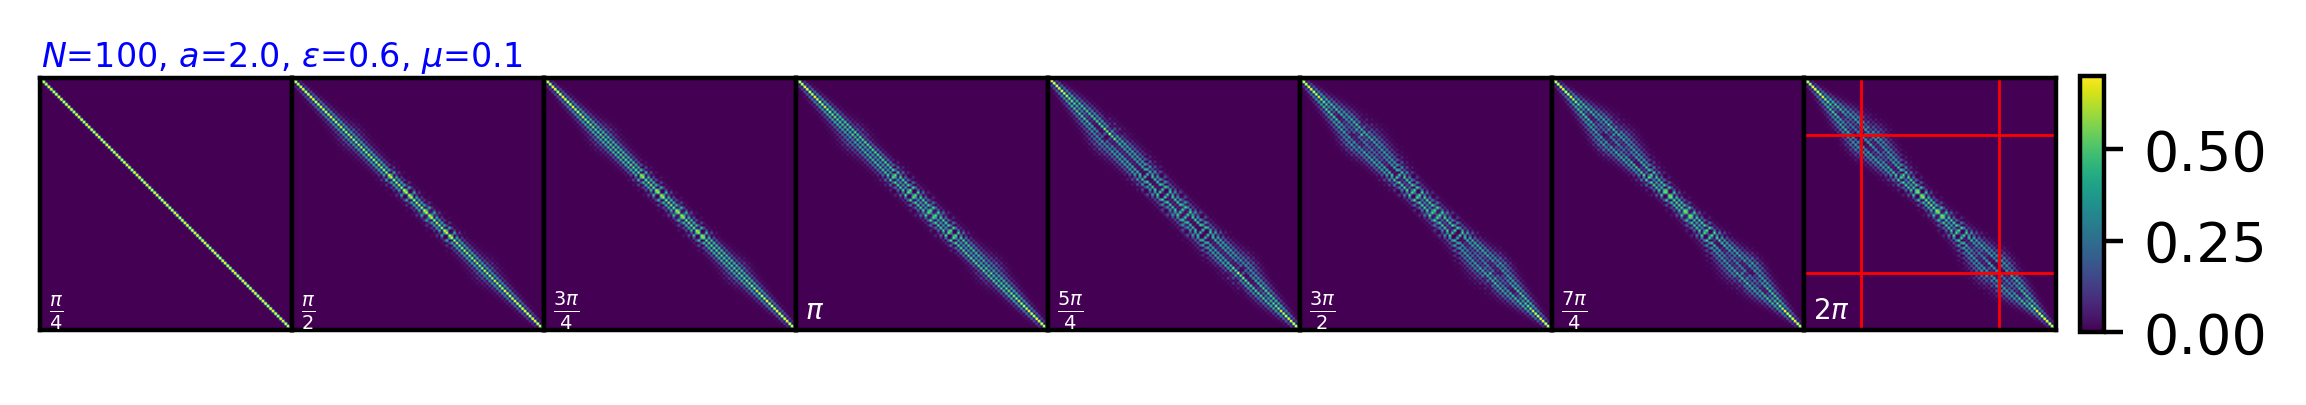

In [252]:
def do8(n,a,eps,mu,ofile):
    #a = 1.0; eps=1.0; mu=0.05;  
    mup = mu;
    b=0.; taushift=0.
    #n = 100; 
    ntau = n*4
    h0 = hat_h_0_new(n,a,eps)  
    w, vr = eigs_h0(n,a,eps)
    
    nw=8
    fig,axarr = plt.subplots(1,nw,figsize=(6,1),dpi=400)
    plt.subplots_adjust(hspace=0,wspace=0,top=0.99,right=0.85,bottom=0.01,left=0.01)
    
    for k in range(nw):
        ftau = int(k*ntau/nw)
        w_s,vr_s,U_final  = U_prop3(n,ntau,a,b,eps,mu,mup,taushift,ftau)
        ela = el_matrix(vr,U_final)
        if (k==0):
            vmin = np.min(np.abs(ela))
            vmax = np.max(np.abs(ela))
        im=axarr[k].imshow(np.abs(ela),vmin=vmin,vmax=vmax*0.7)
        axarr[k].set_yticks([])
        axarr[k].set_xticks([])
    cax= fig.add_axes([0.86,0.18,0.01,0.64])
    plt.colorbar(im,cax=cax)
    clabel = r'$N$={:0}, $a$={:.1f}, $\epsilon$={:.1f}, $\mu$={:.1f}'.format(n,a,eps,mu)
    axarr[0].text(0,-5,clabel,color='blue',fontsize=6)

    E1 = eps
    E2 = 2*a - eps
    i1 = np.argmin(np.abs(w - E1))
    i2 = np.argmin(np.abs(w - E2))
    axarr[nw-1].plot([0,n-1],[i1,i1],'r-',lw=0.5)
    axarr[nw-1].plot([i1,i1],[0,n-1],'r-',lw=0.5)
    axarr[nw-1].plot([0,n-1],[i2,i2],'r-',lw=0.5)
    axarr[nw-1].plot([i2,i2],[0,n-1],'r-',lw=0.5)

    alabels8 = [r'$\frac{\pi}{4}$', r'$\frac{\pi}{2}$', r'$\frac{3\pi}{4}$', r'$\pi$', \
                   r'$\frac{5\pi}{4}$', r'$\frac{3\pi}{2}$',  r'$\frac{7\pi}{4}$', r'$2\pi$']
    alabels4 = [r'$\frac{\pi}{2}$', r'$\pi$', \
                   r'$\frac{3\pi}{2}$', r'$2\pi$']
    
    for k in range(nw):
        axarr[k].text(3,n-5,alabels8[k],fontsize=5,color='white')
       
    if (len(ofile) >3):
        plt.savefig(ofile)
        
    plt.show()

a = 2.0; eps=2.0; mu=0.05; n=100
do8(n,a,eps,mu,'puf1.png')
a = 2.0; eps=0.6; mu=0.05; n=100
do8(n,a,eps,mu,'puf2.png')
# showing matrix elements in basis of h0

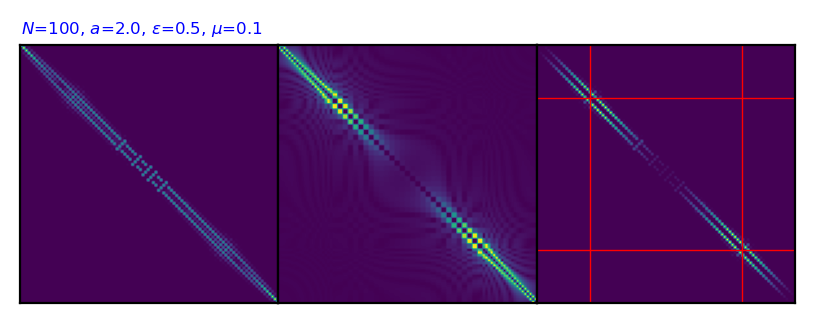

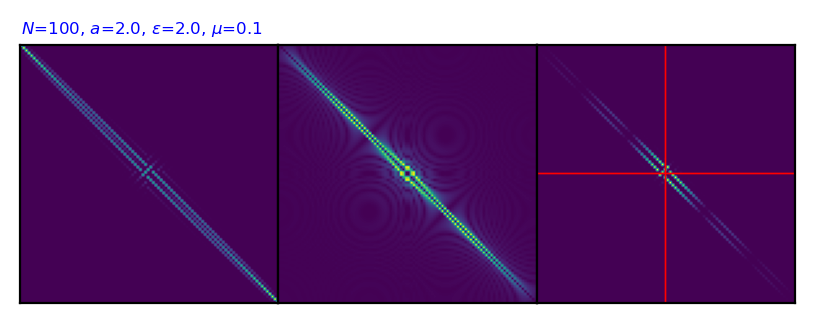

In [251]:
def new_pic(n,a,eps,mu):
    c_op = cos_phi_op(n)
    h0 = hat_h_0_new(n,a,eps)
    w, vr = eigs_h0(n,a,eps)
    cop_jk = el_matrix(vr,c_op)
    mat  = np.zeros((n,n),dtype = complex)
    mat_V = np.zeros((n,n),dtype = complex)
    for j in range(n):
        for k in range(n):
            E_jk = w[j]- w[k]
            fac1 = np.exp(1j*n*E_jk) - 1.0
            fac2 = (n*E_jk/(2*np.pi))**2 - 1.0
            fac3 = n*E_jk/(2*np.pi)
            fac4 = 1.0/(2*np.pi)
            #fac4 = 1.0 - 0.5j*n*E_jk - (n*E_jk)**2/12.0
            if (fac3 !=0):
                mat[j,k] = fac1*fac3*fac4/fac2 
                #mat_V = fac1*fac3*fac4/fac2
    mat *= mu*n/(2*np.pi)  # these are the functions for hat_F_{jk}
    mat_V *= 1/(2*np.pi)   # these are the functions for V_{jk}
    nw=3
    fig,axarr= plt.subplots(1,nw,figsize=(5,2),dpi=200)
    plt.subplots_adjust(hspace=0,wspace=0)
    axarr[0].imshow(np.abs(cop_jk))
    axarr[1].imshow(np.abs(mat))
    axarr[2].imshow(np.abs(mat*cop_jk))
    #axarr[3].imshow(np.abs(mat_V*cop_jk))
    for k in range(nw):
        axarr[k].set_yticks([])
        axarr[k].set_xticks([])
    clabel = r'$N$={:0}, $a$={:.1f}, $\epsilon$={:.1f}, $\mu$={:.1f}'.format(n,a,eps,mu)
    #clabel = r'$N$={:0}, $a$={:.1f}, $\epsilon$={:.1f}'.format(n,a,eps)
    axarr[0].text(0,-5,clabel,color='blue',fontsize=6)

    E1 = eps
    E2 = 2*a - eps
    i1 = np.argmin(np.abs(w - E1))
    i2 = np.argmin(np.abs(w - E2))
    axarr[nw-1].plot([0,n-1],[i1,i1],'r-',lw=0.5)
    axarr[nw-1].plot([i1,i1],[0,n-1],'r-',lw=0.5)
    axarr[nw-1].plot([0,n-1],[i2,i2],'r-',lw=0.5)
    axarr[nw-1].plot([i2,i2],[0,n-1],'r-',lw=0.5)
    
    plt.show()

n=100;a=2.;eps=0.5; mu=0.1
new_pic(n,a,eps,mu) 
a=2.;eps=a;
new_pic(n,a,eps,mu)

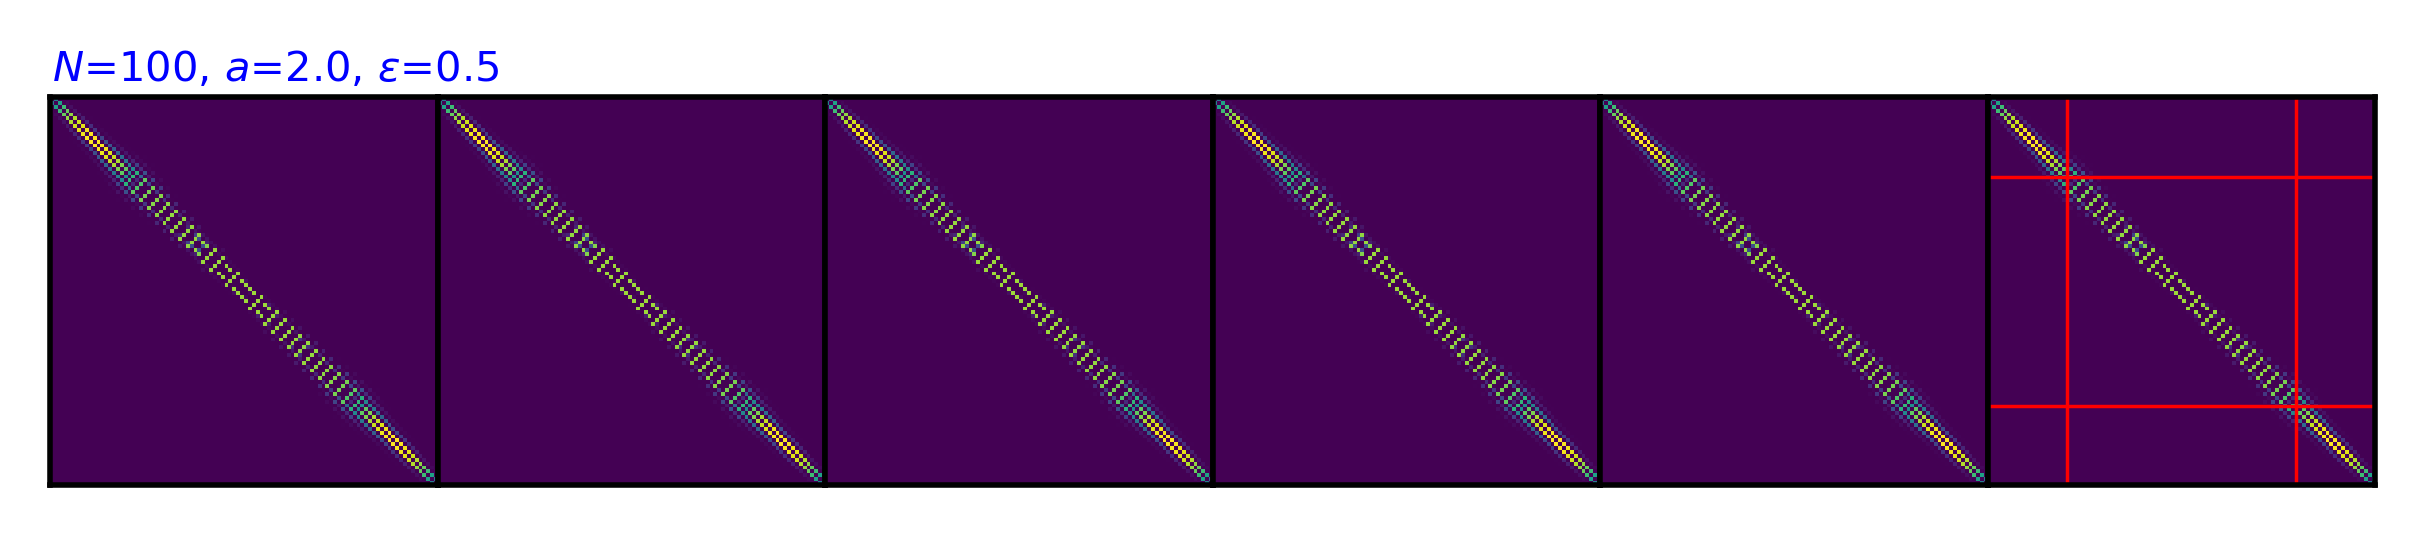

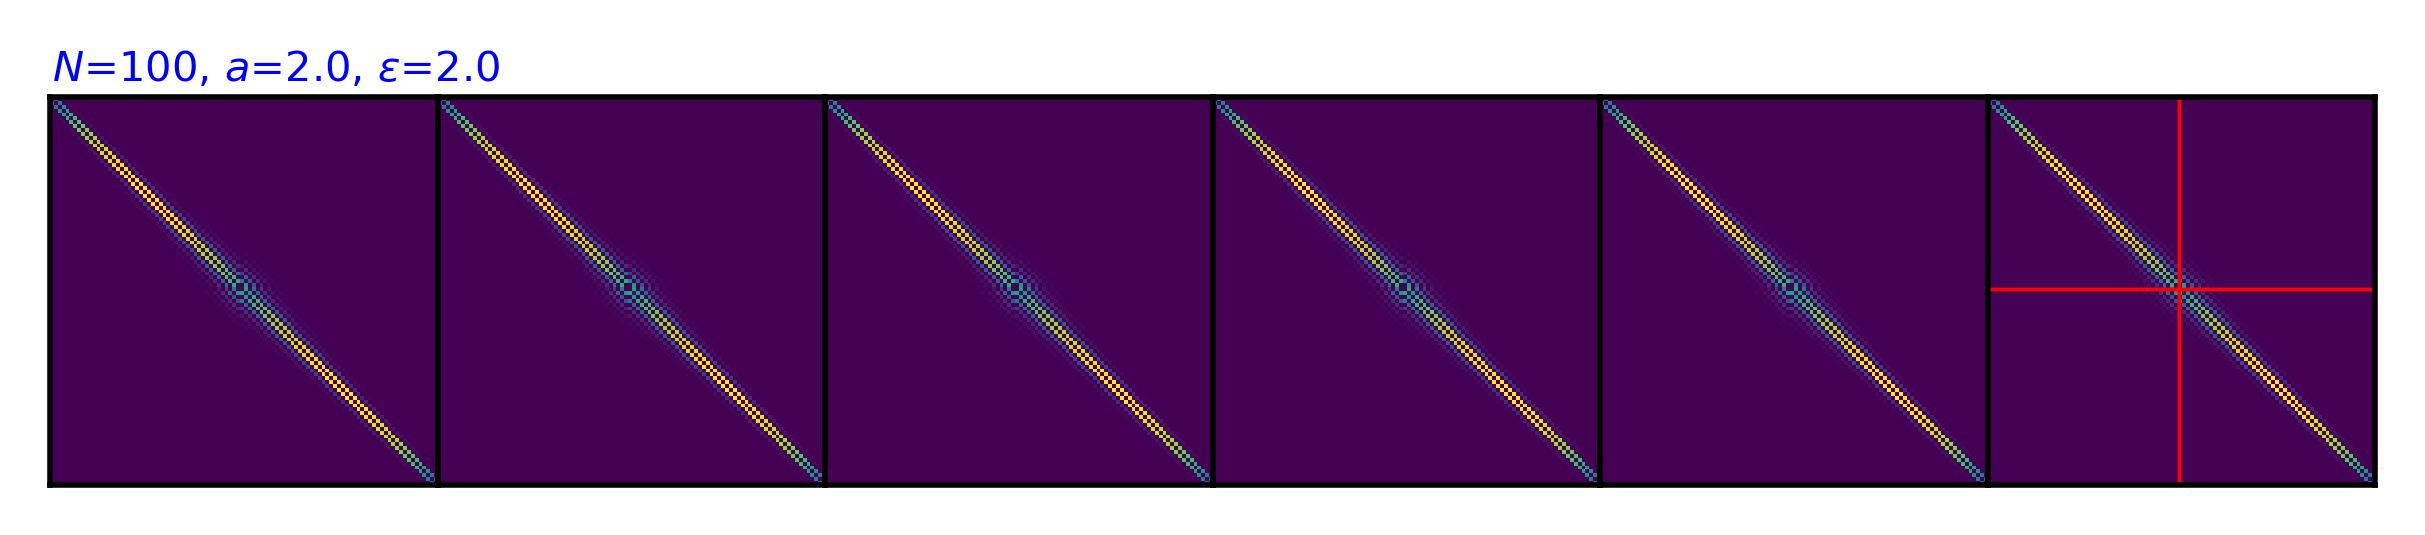

In [227]:
def somseries(n,a,eps,ofile):
    s_op = sin_phi_op(n)
    h0 = hat_h_0_new(n,a,eps)
    w, vr = eigs_h0(n,a,eps)
    sop_jk = el_matrix(vr,s_op)
    #asum1,pp = Vjksum(sop_jk,1)
    #asum2,pp = Vjksum(cop_jk,1)
    nw=6
    fig,axarr= plt.subplots(1,nw,figsize=(6,2),dpi=500)
    plt.subplots_adjust(hspace=0,wspace=0)
    for k in range(nw):
        im=axarr[k].imshow(np.abs(sop_jk))
        cop_jk = el_matrix(vr,s_op)
        s_op = commutator(h0, s_op)
        axarr[k].set_xticks([])
        axarr[k].set_yticks([])
    
    E1 = eps
    E2 = 2*a - eps
    i1 = np.argmin(np.abs(w - E1))
    i2 = np.argmin(np.abs(w - E2))

    axarr[nw-1].plot([0,n-1],[i1,i1],'r-',lw=0.5)
    axarr[nw-1].plot([i1,i1],[0,n-1],'r-',lw=0.5)
    axarr[nw-1].plot([0,n-1],[i2,i2],'r-',lw=0.5)
    axarr[nw-1].plot([i2,i2],[0,n-1],'r-',lw=0.5)
    clabel = r'$N$={:0}, $a$={:.1f}, $\epsilon$={:.1f}'.format(n,a,eps)
    axarr[0].text(0,-5,clabel,color='blue',fontsize=6)

    if (len(ofile)>3):
        plt.savefig(ofile)
    
    plt.show()

n=100;a=2.;eps=0.5; 
somseries(n,a,eps,'')
a=2.;eps=a;
somseries(n,a,eps,'')

#  not interesting!

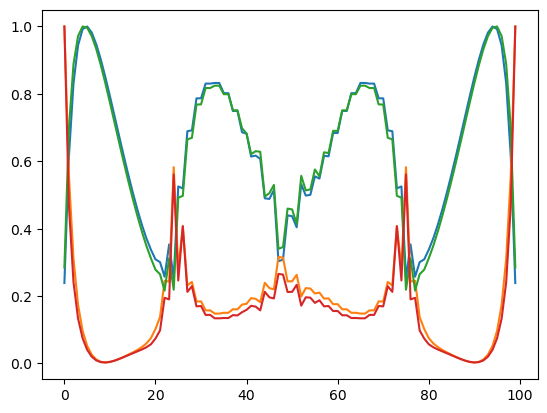

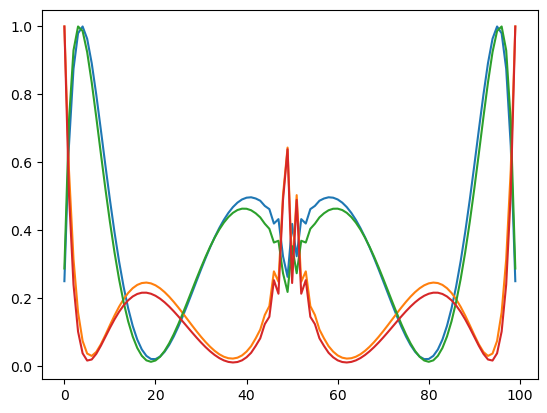

In [170]:
def try_c(n,a,eps):
    c_op = cos_phi_op(n)
    s_op = sin_phi_op(n)
    h0 = hat_h_0_new(n,a,eps)
    sop = commutator(h0,s_op)
    sop = np.matmul(sop,sop)
    w, vr = eigs_h0(n,a,eps)
    for k in range(5):
        sop_jk = el_matrix(vr,sop)
        asum,pp = Vjksum(sop_jk,1)
        if (k >0):
            plt.plot(asum/max(asum),'-',ms=2)
        sop = commutator(s_op,np.copy(sop))
        #if (k%2 ==0):
        #    sop = commutator(s_op,np.copy(sop))
        #else:
        #    sop = commutator(s_op,np.copy(sop))
        
    plt.show()

n=100;a=1.5;eps=0.5;
try_c(n,a,eps)
n=100;a=1.0;eps=1.0;
try_c(n,a,eps)

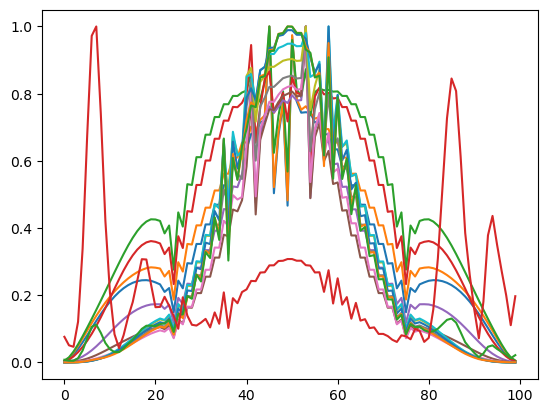

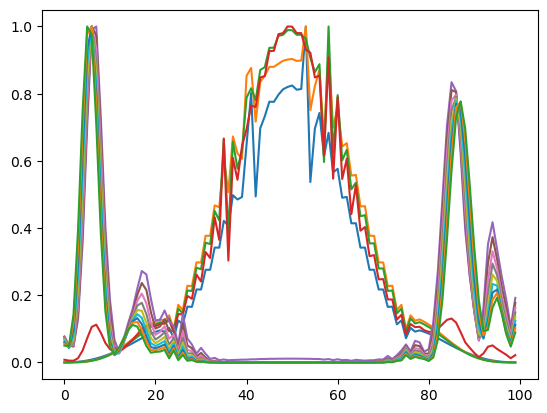

In [160]:
def try_a(n,a,eps):
    c_op = cos_phi_op(n)
    h0 = hat_h_0_new(n,a,eps)
    sop = commutator(h0,c_op)
    w, vr = eigs_h0(n,a,eps)
    for k in range(15):
        sop_jk = el_matrix(vr,sop)
        asum,pp = Vjksum(sop_jk,1)
        if (k >0):
            plt.plot(asum/max(asum),'-',ms=2)
        #sop = commutator(c_op,np.copy(sop))
        sop = commutator(h0,np.copy(sop))
        
    plt.show()

def try_b(n,a,eps):
    c_op = cos_phi_op(n)
    h0 = hat_h_0_new(n,a,eps)
    sop = commutator(h0,c_op)
    w, vr = eigs_h0(n,a,eps)
    mat = np.zeros((n,n),dtype=complex)
    matmul = mat
    for j in range(n):
        E_j = w[j]
        for k in range(n):
            E_k = w[k]
            E_jk = E_j - E_k 
            mat[j,k] = E_jk
    for k in range(15):
        sop = commutator(h0,np.copy(sop))
        sop_jk = el_matrix(vr,sop)
        matmul = np.multiply(mat,matmul)
        asum,pp = Vjksum(sop_jk,matmul)
        if (k >1):
            plt.plot(asum/max(asum),'-',ms=2)
        
    plt.show()

n=100;a=1.5;eps=0.5;
try_a(n,a,eps)
try_b(n,a,eps)


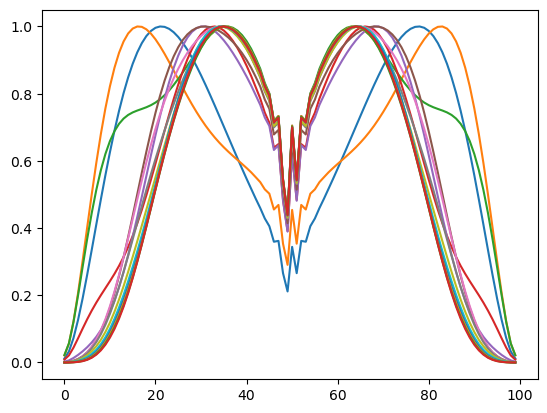

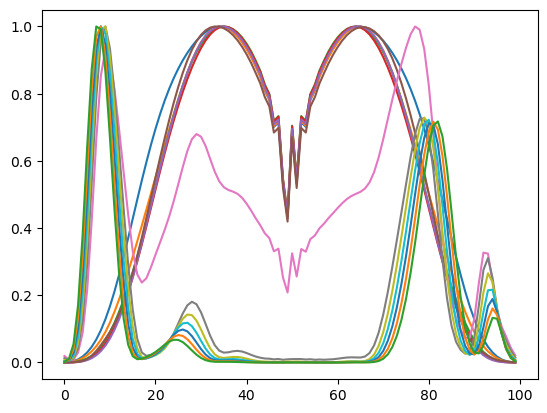

In [161]:
n=100;a=1.0;eps=1.0;
try_a(n,a,eps)
try_b(n,a,eps)

#### really illustrates that separatrix is the one!

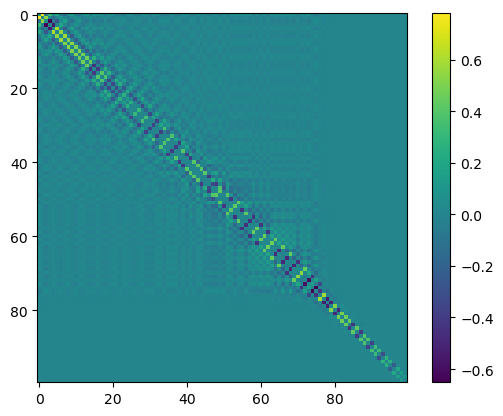

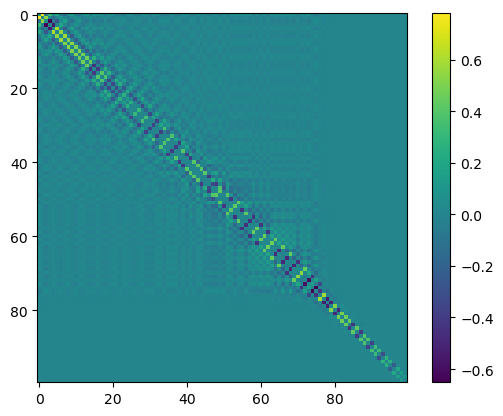

In [181]:
# trying sqrts of cosine and sine ops
def sqcos(n):
    z = np.zeros((n,n), dtype = complex)
    for k in range(n):
        fac = 1.0/np.cos(np.pi*k/n)
        #if (fac !=0):
        z[k,k] = np.cos(np.pi*k/n)
    return z

def sqsin(n):
    z = np.zeros((n,n), dtype = complex)
    for k in range(n):
        fac = 1.0/np.cos(np.pi*k/n)
        #if (fac !=0):
        z[k,k] = np.sin(np.pi*k/n)
    return z

a = 1.5; eps=0.5; n=100
h0 = hat_h_0_new(n,a,eps)  
w, vr = eigs_h0(n,a,eps)
cq = sqcos(n)
sq = sqcos(n)
els = el_matrix(vr,cq)
elc = el_matrix(vr,sq)
im = plt.imshow(np.real(els))
plt.colorbar(im)
plt.show()
im = plt.imshow(np.real(elc))
plt.colorbar(im)
plt.show()

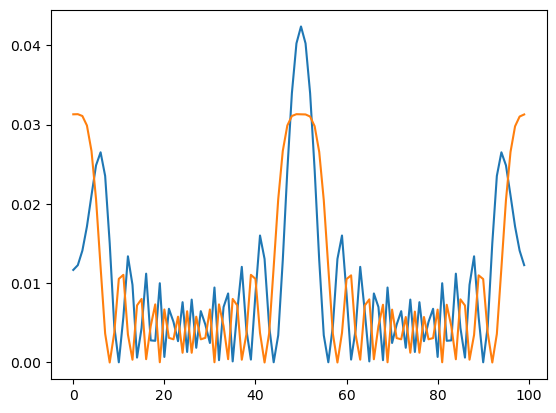

In [127]:
# what sep orbit looks like 
a = 1.0; eps=1.0
h0 = hat_h_0_new(n,a,eps)  
w, vr = eigs_h0(n,a,eps)
#plt.plot(np.abs(vr[:,53])**2)#
plt.plot(np.abs(vr[:,51])**2)#
#plt.plot(np.real(vr[:,50])**2)
plt.plot(np.real(vr[:,49])**2)
plt.show()
# this is what the sep orbit is supposed to look like because at phi=0, pi, there is a concentration 

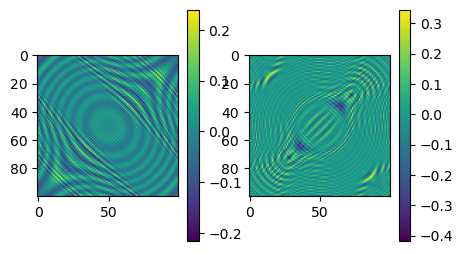

In [88]:
# what U_T looks like in regular [j> basis
b=0.; taushift=0.0
n = 100; ntau = n*4
a = 1.0; eps=a; mu=0.1;  mup = mu;
ftau = int(ntau)
w_s,vr_s,U_final1  = U_prop3(n,ntau,a,b,eps,mu,mup,taushift,ftau)
fig,axarr = plt.subplots(1,2,figsize=(5,3))
im=axarr[0].imshow(np.real(U_final))
plt.colorbar(im)
w_s,vr_s,U_final0  = U_prop3(n,ntau,a,b,eps,0,0,taushift,ftau)
im=axarr[1].imshow(np.real(U_final1-U_final0))
plt.colorbar(im)
plt.show()

In [186]:
n = 200
a = 1.5
eps = 0.5
w, vr = eigs_h0(n,a,eps)
mu = 0.05; mup = mu; b = 0.0; taushift=0.0; ntau = 500

H0op = hat_h_0_new(n,a,eps) 
w,vr = eigs_h0(n,a,eps)  # eigenvals of h0 sorted 

w_s,vr_s,U_final  = U_prop2(n,ntau,a,b,eps,mu,mup,taushift) # create prop
wsort,vrsort,expsort,sigsort = esort_op(w_s,vr_s,H0op)  # sort eigenvecs of prop in order of <h0>
mat = state_prod(vr,vrsort)

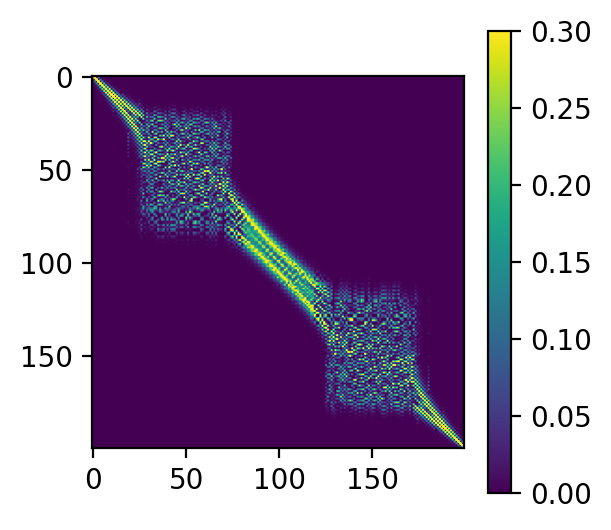

In [187]:
fig,ax = plt.subplots(1,1,figsize=(3,3),dpi=200)
im = ax.imshow(np.absolute(mat),vmax=0.3)
plt.colorbar(im)
plt.show()
# this definitely shows the chaotic region 